This is a temporary notebook and will be refactored once the analysis is finalized. Core logic will be moved into reusable functions under src/ to improve readability, reduce large code blocks, and optimize performance.

# Background

The Older Adults with Cancer Clinic (OACC) identifies the unique needs of cancer patients over age 65 by performing geriatric assessments (GAs) to assess treatment fitness and suggest treatment modifications. The clinic has the following outcomes for patients:

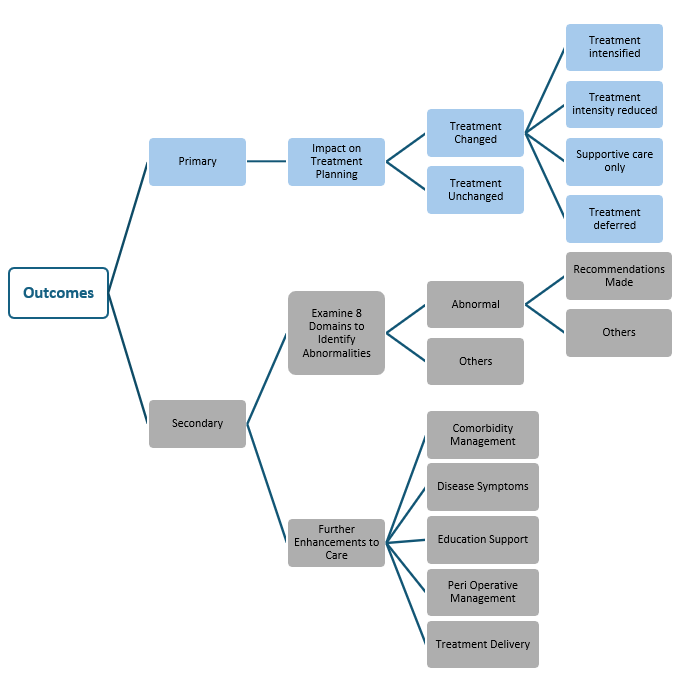

Given the rising number of referrals, limited resources, and increasing wait times, the clinic is considering changing the age cutoff from 65 to 75, based on the assumption that their services would be more beneficial for the older age group. But is this truly the case? 

The objective of this study was to compare whether the GA has similar impact on primary and secondary outcomes of the clinic for patients under 75 compared to those over 75.

To address the study's objective, we used descriptive analytics to compare primary and secondary outcomes of GA between patients under 75 and those over 75. We then applied chi-square tests to determine if these differences were statistically significant at 0.05 significance level.


# 0. Import Packages

In [ ]:
# Import packages
import pandas_access as mdb
import pandas as pd
import os
import pyodbc
import matplotlib.pyplot as plt
import numpy as np
import pkg_resources
import pretty_jupyter
from scipy.stats import chi2_contingency
from IPython.display import display

In [ ]:
# Set the maximum number of columns displayed
pd.set_option('display.max_columns', None)

In [ ]:
# Adjust display options to ensure all rows and columns are shown
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.expand_frame_repr = False

# 1. Read and clean data

## 1.1. Read data

In [ ]:
# Get table names

try:
    # Set up connection parameters
    db_path = r"C:\OACC Patient Database 2025-01-09.accdb"
    conn_str = (
        r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
        rf"DBQ={db_path};"
    )

    # Connect to the database
    conn = pyodbc.connect(conn_str)

    # Get cursor
    cursor = conn.cursor()

    # Get list of tables
    tables = cursor.tables()

    # Extract table names
    table_names = [table.table_name for table in tables if table.table_type == "TABLE"]

    # Print list of table names
    print("Tables in the database:")
    for name in table_names:
        print(name)

except Exception as e:
    print("An error occurred:", e)

finally:
    # Close the connection
    if 'conn' in locals():
        conn.close()


In [ ]:
# Read data

try:
    # Set up connection parameters
    db_path = r"C:\OACC Patient Database 2025-01-09.accdb"
    conn_str = (
        r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
        rf"DBQ={db_path};"
    )

    # Connect to the database
    conn = pyodbc.connect(conn_str)

    # Read the "Patients" table into a pandas DataFrame
    query = "SELECT * FROM Patients;"
    df_original = pd.read_sql(query, conn)

except Exception as e:
    print("An error occurred:", e)

finally:
    # Close the connection
    if 'conn' in locals():
        conn.close()


In [ ]:
# df_original.tail()

## 1.2. Create lists of specific columns for future use

In [ ]:
# Print all column names
column_names = df_original.columns.tolist()
print(column_names)

In [ ]:
# Define a list of geriatric domains
domain_cols = [
    'Comorbidities',
    'FunctionalStatusIADLs',
    'FunctionalStatusPhys',
    'FallsRisk',
    'MedicationOptimization',
    'SocialSupports',
    'Nutrition',
    'Mood',
    'Cognition'
]

In [ ]:
# Define a list of recommendation columns
rec_cols= [
    'ComorbiditiesRec',
    'FunctionalStatusRec',
    'FallsRiskRec',
    'MedicationOptimizationRec',
    'SocialSupportsRec',
    'NutritionRec',
    'MoodRec',
    'CognitionRec'
]

In [ ]:
# Define a list of enhancement columns
enhance_cols = [
    'EnhanceTrmtDelivery',
    'EnhanceComorbMngmt',
    'EnhanceEduSupport',
    'EnhanceDiseaseSymptoms',
    'EnhancePeriOpMgmt'
]

## 1.3. Make changes to columns

### 1.3.1. AgeGroup

In [ ]:
# Create 'AgeGourp' column
df_original['AgeGroup'] = np.where(df_original['Age'] < 75, '<75', '>=75')

### 1.3.2. TreatmentImpact

In [ ]:
# Replace specific values in the 'TreatmentImpact' column directly
df_original['TreatmentImpact'] = np.where(
    df_original['TreatmentImpact'].isin(['Treatment intensity reduced', 'Supportive care only', 'Treatment intensified', 'Treatment deferred']),
    'Treatment changed',
    df_original['TreatmentImpact']
)

### 1.3.3. Domain columns

In [ ]:
# Rename FunctionalStatus column
df_original.rename(columns={'FunctionalStatus': 'Functional_Status'}, inplace=True)

In [ ]:
# Dictionary to store unique values for each column
domain_values_dict = {}

# Loop through each column in domain_cols
for col in domain_cols:
    if col in df_original.columns:
        # Get unique values, including NaN, None, and blanks
        unique_values = df_original[col].replace('', 'BLANK').fillna('NULL').unique()
        # Store unique values in the dictionary
        domain_values_dict[col] = unique_values

# Print the resulting dictionary
for key, value in domain_values_dict.items():
    print(f"{key}: {value}")

In [ ]:
# Define "normal" values for each geriatric domain
domain_values_dict_normal = {
'Comorbidities': ['Low', 'Deferred'],
'FunctionalStatusIADLs': ['Independent', 'Deferred'],
'FunctionalStatusPhys': ['Normal', 'Deferred'],
'FallsRisk': ['Not increased', 'Deferred'],
'MedicationOptimization': ['No issues', 'Deferred'],
'SocialSupports': [ 'Good', 'Deferred'],
'Nutrition': ['Normal', 'Deferred'],
'Mood': ['Normal', 'Unable to assess fully', 'Deferred'],
'Cognition': ['Normal', 'Borderline/Req. further testing', 'Deferred']
}

In [ ]:
# Define "abnormal" values for each geriatric domain
domain_values_dict_abnormal = {
'Comorbidities': ['Moderate', 'High'],
'FunctionalStatusIADLs': ['Dependent in 1+ IADLs'],
'FunctionalStatusPhys': ['Decreased physical per.'],
'FallsRisk': ['Increased'],
'MedicationOptimization': ['Potential for optimization'],
'SocialSupports': ['Vulnerable', 'None'],
'Nutrition': ['At risk', 'Malnourished'],
'Mood': ['Depressed'],
'Cognition': ['Abnormal']
}

In [ ]:
# Replace specific values in geriatric columns directly
for col in domain_values_dict_normal.keys():
    if col in df_original.columns:
        df_original[col] = df_original[col].apply(
            lambda x: 'Normal' if x in domain_values_dict_normal[col]
            else 'Abnormal' if x in domain_values_dict_abnormal.get(col, [])
            else x
        )

In [ ]:
# Creating a new column 'FunctionalStatus' to classify rows as 'Abnormal'
# if either 'FunctionalStatusIADLs' or 'FunctionalStatusPhys' is 'Abnormal'; otherwise, set it to 'Normal'
df_original['FunctionalStatus'] = df_original.apply(
    lambda row: 'Abnormal' if row['FunctionalStatusIADLs'] == 'Abnormal' or row['FunctionalStatusPhys'] == 'Abnormal' else 'Normal', 
    axis=1
)

### 1.3.4. Recommendation columns

In [ ]:
# Collect unique values into a set
unique_values_set = set()
for rec_col in rec_cols:
    unique_values_set.update(df_original[rec_col].unique())

print("Unique values across all recommendation columns:", unique_values_set)

In [ ]:
# Replace 'no recommendations' and 'recommendations deferred' with 'No or Deferred Recommendations'
for col in rec_cols:
    if col in df_original.columns:
        df_original[col] = df_original[col].replace(
            {'No recommendations': 'No or Deferred Recommendations',
             'Recommendations deferred': 'No or Deferred Recommendations'}
        )

### 1.3.5. DiseaseSite

In [ ]:
# Count the frequency of each unique value in the 'DiseaseSite' column
frequency_data = df_original['DiseaseSite'].value_counts()
print(frequency_data)

In [ ]:
# Replace 'gu' with 'GU'
df_original['DiseaseSite'] = df_original['DiseaseSite'].replace('gu', 'GU')

In [ ]:
# List of DiseaseSites to map to 'Others'
values_to_map = ['Myeloma', 'Leukemia', 'Melanoma', 'Other', 'Sarcoma', 'Thyroid', 'Skin (not melanoma)', 'CNS', 'Eye', 'meningioma']

# Create the new column
df_original['mapped_DiseaseSite'] = df_original['DiseaseSite'].apply(lambda x: 'Others' if x in values_to_map else x)

### 1.3.6. DiseaseStage

In [ ]:
# Replace blank and placeholder values with NaN
df_original['DiseaseStage'] = df_original['DiseaseStage'].replace(['', 'n/a', 'N/A'], np.nan)

# Count frequencies, including NaN
frequency_data = df_original['DiseaseStage'].value_counts(dropna=False)

print(frequency_data)

In [ ]:
# Define the list of disease sites that are considered hematologic
hematologic_sites = ['Leukemia', 'Lymphoma', 'Myeloma']

# Update the 'DiseaseStage' column to 'Hematologic' 
# only where DiseaseSite is in the hematologic_sites list
df_original.loc[
    df_original['DiseaseSite'].isin(hematologic_sites),
    'DiseaseStage'
] = 'Hematologic'

In [ ]:
# Replace blank and placeholder values with NaN
df_original['DiseaseStage'] = df_original['DiseaseStage'].replace(['', 'n/a', 'N/A'], np.nan)

# Count frequencies, including NaN
frequency_data = df_original['DiseaseStage'].value_counts(dropna=False)

print(frequency_data)

### 1.3.7. VES13Score

In [ ]:
# Map values in VES13Score
df_original['mapped_VES13Score'] = df_original['VES13Score'].apply(
    lambda x: '<3' if pd.to_numeric(x, errors='coerce') < 3 else 
              '>=3' if pd.to_numeric(x, errors='coerce') >= 3 else x
)

In [ ]:
# Print unique combinations
unique_combinations = df_original[['VES13Score', 'mapped_VES13Score']].drop_duplicates()
print(unique_combinations)

# 2. Data Exploration

## 2.1. Trend

In [ ]:
# Plot the Number of Referrals by Year

# Convert 'DateReferred' to datetime
df_original['DateReferred'] = pd.to_datetime(df_original['DateReferred'])

# Extract year from 'DateReferred'
df_original['YearReferred'] = df_original['DateReferred'].dt.year

# Group by year and count number of 'mrn'
yearly_counts = df_original.groupby('YearReferred')['MRN'].count()

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_counts.index, yearly_counts.values, color='xkcd:dark lavender')
plt.title('Number of MRNs by Year of Referral')
plt.xlabel('Year')
plt.ylabel('Number of MRNs')
plt.xticks(yearly_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.show()

In [ ]:
# Plot the number of referrals by Year-Month

# Extract year and month from 'DateReferred'
df_original['YearMonth'] = df_original['DateReferred'].dt.to_period('M')

# Group by year and month and count number of 'MRN'
monthly_counts = df_original.groupby('YearMonth')['MRN'].count()

# Convert the PeriodIndex to datetime for better plotting
monthly_counts.index = monthly_counts.index.to_timestamp()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color='tab:purple')
plt.title('Number of MRNs by Month of Referral')
plt.xlabel('Month')
plt.ylabel('Number of MRNs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Adding data labels to the plot
for x, y in zip(monthly_counts.index, monthly_counts.values):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# 3. Patient flow diagram

In this section, we will filter the DataFrame step-by-step to prepare it for various purposes, including the analysis of primary and secondary outcomes. The final outputs of this process are three DataFrames: `primary_outcome_df`, `secondary_outcomes_df`, and `perioperative_mng_df`. Detailed information on how each will be used is provided below.

**1. Primary Outcome (Treatment Impact)**  
`primary_outcome_df` will be used for analyzing the primary outcome, which is the clinic's impact on the treatment plan.

**2. Secondary Outcomes**

- **2.1 Geriatric Domains**  
  `secondary_outcomes_df` will be used for detection of abnormal conditions in various geriatric domains.

- **2.2 Recommendations**  
  `secondary_outcomes_df` will be filtered for each geriatric domain separately to retain only patients with abnormal conditions in that domain, followed by analyzing the recommendations for the retained records.
- **2.3 Enhancements**  
  - For most enhancements, all records from `secondary_outcomes_df` will be used, except for **peri-operative management**.  
  - For **peri-operative management**, we create `perioperative_mng_df` by applying an additional filter: `finaltreatmentsurgery = True`.

## 3.1. Total

In [ ]:
# Creating a copy to preserve the original DataFrame
df=df_original.copy()

In [ ]:
# Total number of records
num_records= len(df)
print(num_records)

## 3.2. Filter 'DateReferred'

In [ ]:
# Filter the dataframe to include rows where 'DateReferred' is between 2015-07-01 and 2024-07-01
df = df[(df["DateReferred"] >= "2015-07-01") & (df["DateReferred"] < "2024-07-01")]

# Count the records after filtering by 'DateReferred'
count_after_DateReferred_filter=len(df)
print(count_after_DateReferred_filter)

## 3.3. Filter 'PatientReferralStatus'

In [ ]:
# Count all values in 'PatientReferralStatus', including NaN and blanks
PatientReferralStatus = df['PatientReferralStatus'] \
    .replace('', 'Blank') \
    .fillna('NaN') \
    .value_counts()

# Print the counts
print(PatientReferralStatus)

In [ ]:
# Filter the dataframe to include rows where 'PatientReferralStatus' is 'New patient'
df = df[df['PatientReferralStatus'] == 'New patient']

# Count the records after filtering by 'PatientReferralStatus'
count_after_PatientReferralStatus_filter= len(df)
print(count_after_PatientReferralStatus_filter)

In [ ]:
# Check if the '1stAppointmentDate' column contains any null values
df['1stAppointmentDate'].isnull().any()

## 3.4. Filter 'age'

In [ ]:
# Filter the dataframe to include rows where 'Age' >= 65
df = df[df['Age'] >= 65]

# Count the records after filtering by 'Age'
count_after_Age_filter= len(df)
print(count_after_Age_filter)

## 3.5. Filter '1stAppointmentDate'

In [ ]:
# Filter the dataframe to include rows where '1stAppointmentDate' is between 2015-07-01 and 2024-07-01
df = df[(df["1stAppointmentDate"] >= "2015-07-01") & (df["1stAppointmentDate"] < "2024-07-01")]

# Count the records after filtering by '1stAppointmentDate'
count_after_1stAppointmentDate_filter=len(df)
print(count_after_1stAppointmentDate_filter)

## 3.6. Filter incomplete assessments

In [ ]:
# Remove patients with incomplete assessments
df = df[~df['ID'].isin([734, 357])]

# Count the records after filtering out incomplete assessments
count_after_Assessment_filter= len(df)
print(count_after_Assessment_filter)

## 3.7. Filter 'Treatment stage'

In [ ]:
df_all_treatment_stages=df.copy()

In [ ]:
# Count all values in 'TreatmentStage', including NaN and blanks
TreatmentStage = df['TreatmentStage'] \
    .replace('', 'Blank') \
    .fillna('NaN') \
    .value_counts()

# Print the counts
print(TreatmentStage)

In [ ]:
# Filter the DataFrame to include rows where 'TreatmentStage' is 'Pre-treatment' or 'Pre-treatment new modality'
df = df[df['TreatmentStage'].isin(['Pre-treatment', 'Pre-treatment new modality'])]

# Count the records after filtering by 'TreatmentStage'
count_after_TreatmentStage_filter= len(df)
print(count_after_TreatmentStage_filter)

In [ ]:
secondary_outcomes_df=df.copy()

## 3.8. Filter 'TreatmentImpact'

In [ ]:
# Count all values in 'TreatmentImpact', including NaN and blanks
TreatmentImpact = df['TreatmentImpact'] \
    .replace('', 'Blank') \
    .fillna('NaN') \
    .value_counts()

# Print the counts
print(TreatmentImpact)

In [ ]:
# Filter the DataFrame by 'TreatmentImpact'
df = df[df['TreatmentImpact'].isin(['Treatment unchanged', 'Treatment changed'])]

# Count the records after filtering by 'TreatmentImpact'
count_after_TreatmentImpact_filter= len(df)
print(count_after_TreatmentImpact_filter)

In [ ]:
primary_outcome_df= df.copy()

## 3.9. Filter 'FinalTreatmentSurgery'

In [ ]:
# Filter 'secondary_outcomes_df' to include only rows where 'FinalTreatmentSurgery' is True
perioperative_mng_df = secondary_outcomes_df[secondary_outcomes_df['FinalTreatmentSurgery'].eq(True)].copy()

# Count the records after filtering by 'FinalTreatmentSurgery'
count_after_FinalTreatmentSurgery_filter=len(perioperative_mng_df)
print(count_after_FinalTreatmentSurgery_filter)

## 3.10. Summary

In [ ]:
print("Total records in the OACC database:\n", num_records)
print("Records after filtering DateReferred:\n", count_after_DateReferred_filter)
print("Records after excluding patients with a status other than 'New patient':\n", count_after_PatientReferralStatus_filter)
print("Records after excluding occasional patients under 65:\n", count_after_Age_filter)
print("Records after filtering 1stAppointmentDate:\n", count_after_1stAppointmentDate_filter)
print("Records after excluding patients with incomplete assessments:\n", count_after_Assessment_filter)
print("Records after excluding patients who were not referred for pre-treatment advice:\n", count_after_TreatmentStage_filter)
print("Records after excluding patients for whom the treatment impact was not applicable or who experienced unique circumstances:\n", count_after_TreatmentImpact_filter)
print("Records after excluding patients whose final treatment was not surgery:\n", count_after_FinalTreatmentSurgery_filter)

# 4. Baseline Characteristics

In [ ]:
# Define functions

def calculate_mean_sd(data, column):
    """Calculate mean and standard deviation"""
    return f"{data[column].mean():.2f} ({data[column].std():.1f})"

def calculate_counts(data, column):
    """Calculate count and percentage for all unique values, including NaN"""
    counts = data[column].value_counts(dropna=False)
    percentages = (counts / len(data)) * 100
    return counts.index.tolist(), counts.values.tolist(), percentages.tolist()

def add_rows(characteristics, dataframes, column):
    """Add rows for specific characteristics"""
    rows = []
    total_index, total_counts, total_percents = calculate_counts(dataframes['total'], column)
    for value, count, percent in zip(total_index, total_counts, total_percents):
        row = {
            'Characteristics': characteristics,
            'Values': value if pd.notna(value) else 'NaN',
            'Total patients': f"{count} ({percent:.1f})",
            'Age <75': "0 (0.0)",
            'Age ≥75': "0 (0.0)"
        }
        for age_group, df in dataframes.items():
            if age_group != 'total':
                index, counts, percents = calculate_counts(df, column)
                if pd.isna(value):
                    idx = [pd.isna(x) for x in index].index(True) if True in [pd.isna(x) for x in index] else None
                else:
                    idx = index.index(value) if value in index else None
                if idx is not None:
                    row[f"Age {age_group}"] = f"{counts[idx]} ({percents[idx]:.1f})"
        rows.append(row)
    return rows

In [ ]:
# Separate DataFrames by AgeGroup
dataframes = {
    'total': secondary_outcomes_df,
    '<75': secondary_outcomes_df[secondary_outcomes_df['AgeGroup'] == '<75'],
    '≥75': secondary_outcomes_df[secondary_outcomes_df['AgeGroup'] == '>=75']
}

In [ ]:
# Create baseline characteristics DataFrame
baseline_characteristics = pd.DataFrame({
    'Characteristics': ['Age, mean (SD), years'],
    'Values': [''],
    'Total patients': [calculate_mean_sd(dataframes['total'], 'Age')],
    'Age <75': [calculate_mean_sd(dataframes['<75'], 'Age')],
    'Age ≥75': [calculate_mean_sd(dataframes['≥75'], 'Age')]
})

# Add rows for each characteristic
data_columns = [
    ('Gender', 'Gender'),
    ('TreatmentIntent', 'TreatmentIntent'),
    ('DiseaseStage', 'DiseaseStage'),
    ('DiseaseSite', 'mapped_DiseaseSite'),
    ('VES13Score', 'mapped_VES13Score')
]

for characteristic, column in data_columns:
    rows = add_rows(characteristic, dataframes, column)
    baseline_characteristics = pd.concat([baseline_characteristics, pd.DataFrame(rows)], ignore_index=True)

# Display the results
print(baseline_characteristics)

# Save the baseline characteristics to a CSV file
baseline_characteristics.to_csv('baseline_characteristics.csv', index=False)

# 5. Contingency tables and chi-square tests

## 5.1. Primary outcome

In [ ]:
# Placeholder for storing results
PO_Results = []

# Create a contingency table
contingency_table = pd.crosstab(primary_outcome_df['AgeGroup'], primary_outcome_df['TreatmentImpact'])

# Calculate column-wise percentages for the contingency table
percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Determine significance
significance = "Significant" if p < 0.05 else "Not Significant"

# Add an overall summary row
PO_Results.append({
    "Column": "TreatmentImpact",
    "<75": "",
    ">=75": "",
    "Chi2 Statistic": round(chi2, 2),
    "P-Value": round(p, 2) if p > 0.10 else round(p, 3),
    "Degrees of Freedom": dof,
    "Significance": significance
})

# Add rows for each value in the contingency table
for value in contingency_table.columns:
    PO_Results.append({
        "Column": value,
        "<75": f"{contingency_table.loc['<75', value]} ({percentages.loc['<75', value]:.1f}%)",
        ">=75": f"{contingency_table.loc['>=75', value]} ({percentages.loc['>=75', value]:.1f}%)",
        "Chi2 Statistic": "",
        "P-Value": "",
        "Degrees of Freedom": "",
        "Significance": ""
    })

# Convert the results to a DataFrame
PO_Results_df = pd.DataFrame(PO_Results)

# Reorder columns to match the desired format
columns_order = ["Column", "<75", ">=75", "Chi2 Statistic", "P-Value", "Degrees of Freedom", "Significance"]
PO_Results_df = PO_Results_df[columns_order]

# Adjust display options to show all rows and columns like `head()` style
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.expand_frame_repr = False

# Use display() to show the DataFrame
display(PO_Results_df)

# Save the results to a CSV file
PO_Results_df.to_csv("PO_Results.csv", index=False)


## 5.2. Secondary outcomes

### 5.2.1. GA Domains - abnormal

In [ ]:
# Placeholder for storing results
SO_GD_Results = []

# Loop through each domain column
for col in domain_cols:
    # Create a contingency table for AgeGroup and the current domain column
    contingency_table = pd.crosstab(secondary_outcomes_df['AgeGroup'], secondary_outcomes_df[col])

    # Perform the Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Determine significance
    significance = "Significant" if p < 0.05 else "Not Significant"

    # Add an overall summary row
    SO_GD_Results.append({
        "Column": col,
        "<75": "",
        ">=75": "",
        "Chi2 Statistic": round(chi2, 2),
        "P-Value": round(p, 2) if p > 0.10 else round(p, 3),
        "Degrees of Freedom": dof,
        "Significance": significance
    })

    # Add rows for each value in reversed order
    for value in reversed(contingency_table.columns):
        SO_GD_Results.append({
            "Column": value,
            "<75": f"{contingency_table.loc['<75', value]} ({(contingency_table.loc['<75', value] / contingency_table.loc['<75'].sum()) * 100:.1f}%)",
            ">=75": f"{contingency_table.loc['>=75', value]} ({(contingency_table.loc['>=75', value] / contingency_table.loc['>=75'].sum()) * 100:.1f}%)",
            "Chi2 Statistic": "",
            "P-Value": "",
            "Degrees of Freedom": "",
            "Significance": ""
        })

# Convert the results to a DataFrame
SO_GD_Results_df = pd.DataFrame(SO_GD_Results)

# Reorder columns to ensure 'Column' is first
columns_order = ["Column", "<75", ">=75", "Chi2 Statistic", "P-Value", "Degrees of Freedom", "Significance"]
SO_GD_Results_df = SO_GD_Results_df[columns_order]

# Display the dataframe
display(SO_GD_Results_df)

# Save the results to a CSV file
SO_GD_Results_df.to_csv("SO_GD_Results.csv", index=False)

### 5.2.2. GA Domains - recommendations

In [ ]:
# Placeholder for storing results
SO_R_Results = []

# Iterate through each recommendation column
for rec_col in rec_cols:
    # Corresponding column without 'Rec'
    domain_col = rec_col.replace('Rec', '')

    # Filter the DataFrame
    filtered_df = secondary_outcomes_df[
        (secondary_outcomes_df[domain_col] == 'Abnormal') & 
        (secondary_outcomes_df[rec_col].isin(['No or Deferred Recommendations', 'Recommendations made']))
    ]

    # Create a contingency table
    contingency_table = pd.crosstab(filtered_df['AgeGroup'], filtered_df[rec_col])

    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Determine significance
    significance = "Significant" if p < 0.05 else "Not Significant"

    # Add an overall summary row
    SO_R_Results.append({
        "Column": rec_col,
        "<75": "",
        ">=75": "",
        "Chi2 Statistic": round(chi2, 2),
        "P-Value": round(p, 2) if p > 0.10 else round(p, 3),
        "Degrees of Freedom": dof,
        "Significance": significance
    })

    # Add rows for each value in reversed order
    for value in reversed(contingency_table.columns):
        SO_R_Results.append({
            "Column": value,
            "<75": f"{contingency_table.loc['<75', value]} ({(contingency_table.loc['<75', value] / contingency_table.loc['<75'].sum()) * 100:.1f}%)",
            ">=75": f"{contingency_table.loc['>=75', value]} ({(contingency_table.loc['>=75', value] / contingency_table.loc['>=75'].sum()) * 100:.1f}%)",
            "Chi2 Statistic": "",
            "P-Value": "",
            "Degrees of Freedom": "",
            "Significance": ""
        })

# Convert the results to a DataFrame
SO_R_Results_df = pd.DataFrame(SO_R_Results)

# Reorder columns to ensure 'Column' is first
columns_order = ["Column", "<75", ">=75", "Chi2 Statistic", "P-Value", "Degrees of Freedom", "Significance"]
SO_R_Results_df = SO_R_Results_df[columns_order]

# Display the DataFrame
display(SO_R_Results_df)

# Save the results to a CSV file
SO_R_Results_df.to_csv("SO_R_Results.csv", index=False)

### 5.2.3. Enhancements to care

In [ ]:
# List to store all data rows for CSV
SO_E_Results = []

# Loop through each enhancement column
for col in enhance_cols:
    # Determine which DataFrame to use
    if col == 'EnhancePeriOpMgmt':
        df_to_use = perioperative_mng_df
    else:
        df_to_use = secondary_outcomes_df

    # Create a contingency table
    contingency_table = pd.crosstab(df_to_use['AgeGroup'], df_to_use[col])

    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Calculate percentages for the contingency table
    percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

    # Add a header row for the column summary
    SO_E_Results.append({
        '<75': '',
        '>=75': '',
        'Chi2 Statistic': round(chi2, 2),
        'P-Value': round(p, 2) if p > 0.10 else round(p, 3),
        'Degrees of Freedom': dof,
        'Significance': "Significant" if p < 0.05 else "Not Significant",
        'Column': col
    })

    # Add rows for each value in reversed order
    for value in reversed(contingency_table.columns):
        SO_E_Results.append({
            'Column': value,
            '<75': f"{contingency_table.loc['<75', value]} ({percentages.loc['<75', value]:.1f}%)",
            '>=75': f"{contingency_table.loc['>=75', value]} ({percentages.loc['>=75', value]:.1f}%)",
            'Chi2 Statistic': '',
            'P-Value': '',
            'Degrees of Freedom': '',
            'Significance': ''
        })


# Convert the list to a DataFrame
SO_E_Results_df = pd.DataFrame(SO_E_Results)

# Reorder columns to ensure 'Column' is first
columns_order = ['Column', '<75', '>=75', 'Chi2 Statistic', 'P-Value', 'Degrees of Freedom', 'Significance']
SO_E_Results_df = SO_E_Results_df[columns_order]

# Display the DataFrame
display(SO_E_Results_df)

# Save the results to a CSV file
SO_E_Results_df.to_csv("SO_E_Results.csv", index=False)


In [ ]:
# Filter out rows where TreatmentStage is in the list
df_specific_treatment_stages = df_all_treatment_stages[~df_all_treatment_stages['TreatmentStage'].isin(['Pre-treatment', 'Pre-treatment new modality'])].copy()

In [ ]:
df_specific_treatment_stages['TreatmentStage'].value_counts()

In [ ]:
# Filter for rows where TreatmentStage is 'Active surveillance'
df_active = df_specific_treatment_stages[df_specific_treatment_stages['TreatmentStage'] == 'Active surveillance']

In [ ]:
len(df_specific_treatment_stages)

In [ ]:
# Create cross-tab with ReferralReason
df_active['ReferralReason'].value_counts()

In [ ]:
df_specific_treatment_stages[
    (df_specific_treatment_stages['TreatmentStage'] == 'Active surveillance') &
    (df_specific_treatment_stages['ReferralReason'] == 'Treatment decision making')
]

In [ ]:
df_specific_treatment_stages[
    (df_specific_treatment_stages['TreatmentStage'] == 'Active surveillance') &
    (df_specific_treatment_stages['TreatmentImpact'] == 'N/A - treatment already started')
]

In [ ]:
# Create cross-tab with TreatmentImpact
df_active['TreatmentImpact'].value_counts()

In [ ]:
# Define grouped categories
pre_treatment_group = ['Pre-treatment', 'Pre-treatment new modality']
on_treatment_group = ['Maintenance therapy', 'Active treatment']

# Map to descriptive names
def map_stage(stage):
    if stage in pre_treatment_group:
        return 'Pre-treatment (initial or new modality)'
    elif stage in on_treatment_group:
        return 'On-treatment (active or maintenance)'
    elif stage == 'Not on active treatment':
        return 'Cancer survivorship with geriatric issues'
    else:
        return stage  # leave other stages as-is

# Apply grouping
df_all_treatment_stages['StageGrouped'] = df_all_treatment_stages['TreatmentStage'].apply(map_stage)

# Group and count
grouped_counts = df_all_treatment_stages.groupby(['StageGrouped', 'AgeGroup']).size().reset_index(name='RecordCount')

# Pivot to matrix format
matrix = grouped_counts.pivot(index='StageGrouped', columns='AgeGroup', values='RecordCount').fillna(0)

# Calculate column-wise percentages
column_percentages = matrix.div(matrix.sum(axis=0), axis=1) * 100
column_percentages = column_percentages.round(1)

# Display
print(column_percentages)


In [ ]:
# Group and count
grouped_counts = df_all_treatment_stages.groupby(['StageGrouped', 'AgeGroup']).size().reset_index(name='RecordCount')

# Pivot to matrix format
matrix = grouped_counts.pivot(index='StageGrouped', columns='AgeGroup', values='RecordCount').fillna(0)

# Row-wise percentages
row_percentages = matrix.div(matrix.sum(axis=1), axis=0) * 100
row_percentages = row_percentages.round(1)

# Display result
print(row_percentages)


In [ ]:
# Count number of records per grouped TreatmentStage
stage_counts = df_all_treatment_stages['StageGrouped'].value_counts().reset_index()

# Rename columns for clarity
stage_counts.columns = ['TreatmentStage (Grouped)', 'RecordCount']

# Display the result
print(stage_counts)


In [ ]:
# Placeholder for storing results
SO_GD_Results_ = []

# Loop through each domain column
for col in domain_cols:
    # Create a contingency table for AgeGroup and the current domain column
    contingency_table = pd.crosstab(df_specific_treatment_stages['AgeGroup'], df_specific_treatment_stages[col])

    # Perform the Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Determine significance
    significance = "Significant" if p < 0.05 else "Not Significant"

    # Add an overall summary row
    SO_GD_Results_.append({
        "Column": col,
        "<75": "",
        ">=75": "",
        "Chi2 Statistic": round(chi2, 2),
        "P-Value": round(p, 2) if p > 0.10 else round(p, 3),
        "Degrees of Freedom": dof,
        "Significance": significance
    })

    # Add rows for each value in reversed order
    for value in reversed(contingency_table.columns):
        SO_GD_Results_.append({
            "Column": value,
            "<75": f"{contingency_table.loc['<75', value]} ({(contingency_table.loc['<75', value] / contingency_table.loc['<75'].sum()) * 100:.1f}%)",
            ">=75": f"{contingency_table.loc['>=75', value]} ({(contingency_table.loc['>=75', value] / contingency_table.loc['>=75'].sum()) * 100:.1f}%)",
            "Chi2 Statistic": "",
            "P-Value": "",
            "Degrees of Freedom": "",
            "Significance": ""
        })

# Convert the results to a DataFrame
SO_GD_Results__df = pd.DataFrame(SO_GD_Results_)

# Reorder columns to ensure 'Column' is first
columns_order = ["Column", "<75", ">=75", "Chi2 Statistic", "P-Value", "Degrees of Freedom", "Significance"]
SO_GD_Results__df = SO_GD_Results__df[columns_order]

# Display the dataframe
display(SO_GD_Results__df)

# Save the results to a CSV file
SO_GD_Results__df.to_csv("SO_GD_Results_.csv", index=False)

In [ ]:
# Placeholder for storing results
VES13_Impact_Results = []

# Create a contingency table using mapped_VES13Score instead of AgeGroup
contingency_table = pd.crosstab(primary_outcome_df['mapped_VES13Score'], primary_outcome_df['TreatmentImpact'])

# Calculate row-wise percentages
percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Determine significance
significance = "Significant" if p < 0.05 else "Not Significant"

# Add summary row
VES13_Impact_Results.append({
    "Column": "TreatmentImpact",
    "<3 VES-13": "",
    "≥3 VES-13": "",
    "Chi2 Statistic": round(chi2, 2),
    "P-Value": round(p, 2) if p > 0.10 else round(p, 3),
    "Degrees of Freedom": dof,
    "Significance": significance
})

# Loop through each TreatmentImpact category
for value in contingency_table.columns:
    VES13_Impact_Results.append({
        "Column": value,
        "<3 VES-13": f"{contingency_table.loc['<3', value]} ({percentages.loc['<3', value]:.1f}%)" if '<3' in contingency_table.index else "N/A",
        "≥3 VES-13": f"{contingency_table.loc['>=3', value]} ({percentages.loc['>=3', value]:.1f}%)" if '>=3' in contingency_table.index else "N/A",
        "Chi2 Statistic": "",
        "P-Value": "",
        "Degrees of Freedom": "",
        "Significance": ""
    })

# Convert to DataFrame
VES13_Impact_Results_df = pd.DataFrame(VES13_Impact_Results)

# Reorder columns
columns_order = ["Column", "<3 VES-13", "≥3 VES-13", "Chi2 Statistic", "P-Value", "Degrees of Freedom", "Significance"]
VES13_Impact_Results_df = VES13_Impact_Results_df[columns_order]

# Display the table
display(VES13_Impact_Results_df)

# Save to CSV
VES13_Impact_Results_df.to_csv("VES13_Impact_Results.csv", index=False)


In [ ]:
import pandas as pd

# Ensure 1stAppointmentDate is in datetime format
primary_outcome_df['1stAppointmentDate'] = pd.to_datetime(primary_outcome_df['1stAppointmentDate'], errors='coerce')

# Extract year from 1stAppointmentDate
primary_outcome_df['AppointmentYear'] = primary_outcome_df['1stAppointmentDate'].dt.year

# Group by AgeGroup and AppointmentYear, then count
yearly_counts = primary_outcome_df.groupby(['AgeGroup', 'AppointmentYear']).size().reset_index(name='RecordCount')

# Pivot the table for easier reading (optional)
pivot_table = yearly_counts.pivot(index='AppointmentYear', columns='AgeGroup', values='RecordCount').fillna(0).astype(int)

# Display the result
display(pivot_table)
